# **Part two of causal inference** POST TREATMENT DATA ANALYSIS

Goals: we have sent a targeted offer to customers in Market Segment == "Groups" who book more than 90 days out.
Treatment
 - offer 10% off ( on average `$`1500 this costs hotel `$`150)
 - total population of 19811 customer over the period analyzed
 - the test population is 500 customers ( 250 control, 250 treatment)

Evaluate whether offering a 10% discount to eligible guests (e.g., Groups with long lead times) reduces cancellations and increases value versus control.

 # Questions:
 - what effects does this have on cancellations?
 - Is there a return on Investments (ROI)?



Real life Stratification recommendation:

- baseline differences or seasonality: e.g., hotel (City vs Resort), arrival month/season, ADR band, or previous_cancellations>0.

In [2]:
!pip install pytimetk --quiet
import sys; print(sys.executable)  # confirm path
!pip install causalml lightgbm xgboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires dill<0.3.9,>=0.3.0, but you have dill 0.4.0 which is incompatible.
datasets 4.0.0 requires multiprocess<0.70.17, but you have multiprocess 0.70.18 which is incompatible.
/usr/bin/python3
     ━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytimetk as tk
import os
from missingno import matrix

from causalml.inference.tree import UpliftTreeClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.optimize import get_treatment_costs, get_actual_value
from statsmodels.stats.proportion import proportion_confint


from IPython.display import Image
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)


BASE_DIR = "/content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/"

CSV_PATH = os.path.join(BASE_DIR, 'data/hotel_cancellations_experiment2.csv')
# data exploration

Mounted at /content/drive


In [5]:
DATA_DIR = os.path.join(BASE_DIR, "data")
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

In [18]:
# data ----

hotel_experiment_df = pd.read_csv(CSV_PATH)

hotel_experiment_df.glimpse()

<class 'pandas.core.frame.DataFrame'>: 500 rows of 18 columns
is_canceled:                     int64             [0, 1, 1, 1, 0, 1, 0, ...
deposit_type:                    object            ['Non Refund', 'Non R ...
previous_cancellations:          int64             [0, 0, 0, 0, 1, 0, 0, ...
lead_time:                       int64             [129, 143, 267, 173,  ...
total_of_special_requests:       int64             [0, 0, 0, 0, 0, 0, 0, ...
different_room_assigned:         int64             [0, 0, 0, 0, 0, 0, 0, ...
market_segment:                  object            ['Groups', 'Groups',  ...
required_car_parking_spaces:     int64             [0, 0, 0, 0, 0, 0, 0, ...
distribution_channel:            object            ['TA/TO', 'TA/TO', 'T ...
hotel:                           object            ['City Hotel', 'Resor ...
customer_type:                   object            ['Transient', 'Transi ...
previous_bookings_not_canceled:  int64             [0, 0, 0, 0, 0, 0, 0, ...
is_repeated_gu

In [7]:
# 2) EXPERIMENT FACTS
df = hotel_experiment_df.copy()

print("\nHow many people received offers (by arm)?")
display(df['treatment_control'].value_counts(dropna=False))

print("\nHow many accepted the offer?")
acc = df.groupby('treatment_control')['accept_offer'].agg(['sum','count'])
acc = acc.assign(acceptance_rate=lambda x: x['sum']/x['count'])
display(acc)

print("\nCancellation rate per arm:")
cxl = df.groupby('treatment_control')['is_canceled'].agg(['sum','count'])
cxl = cxl.assign(cancellation_rate=lambda x: x['sum']/x['count'])
display(cxl)

print("\nCancellation rate by (arm x accepted):")
cxl2 = df.groupby(['treatment_control','accept_offer'])['is_canceled'].agg(['sum','count'])
cxl2 = cxl2.assign(cancellation_rate=lambda x: x['sum']/x['count'])
display(cxl2)



How many people received offers (by arm)?


,count
treatment_control,
treatment,250
control,250



How many accepted the offer?


,sum,count,acceptance_rate
treatment_control,,,
control,0,250,0.000
treatment,62,250,0.248



Cancellation rate per arm:


,sum,count,cancellation_rate
treatment_control,,,
control,176,250,0.704
treatment,145,250,0.580



Cancellation rate by (arm x accepted):


sum  count  cancellation_rate
treatment_control accept_offer                               
control           0             176    250           0.704000
treatment         0             134    188           0.712766
                  1              11     62           0.177419

[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/exp_cancellations_stacked_control_vs_treatment.png


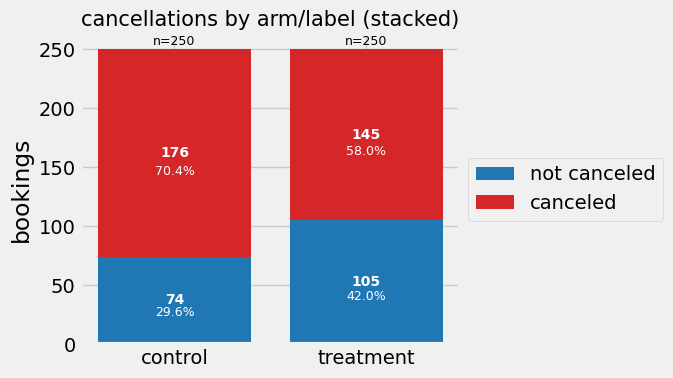

In [8]:
# pivot to get 0/1 counts side by side (ensure both levels exist)
pv = (df.groupby(['treatment_control','is_canceled'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={0:'not_canceled', 1:'canceled'}))

# order bars
labels = ['control','treatment']
pv = pv.reindex(labels)

# heights
not_canceled = pv['not_canceled'].values
canceled     = pv['canceled'].values
totals       = not_canceled + canceled

# per-arm rates
rate_nc = np.divide(not_canceled, totals, out=np.zeros_like(not_canceled, dtype=float), where=totals>0)
rate_c  = np.divide(canceled,     totals, out=np.zeros_like(canceled,     dtype=float), where=totals>0)

fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(labels))

# bottom: not canceled (blue), top: canceled (red)
ax.bar(x, not_canceled, color='tab:blue', label='not canceled')
ax.bar(x, canceled, bottom=not_canceled, color='tab:red', label='canceled')

ax.set_xticks(x, labels)
ax.set_ylabel("bookings")
ax.set_title("cancellations by arm/label (stacked)", fontsize=15)

ymax = max(totals) if len(totals) else 1
for i, (nc, c, t, r_nc, r_c) in enumerate(zip(not_canceled, canceled, totals, rate_nc, rate_c)):
    # positions for counts
    y_nc_cnt = nc/2
    y_c_cnt  = nc + c/2

    # small adaptive offsets for the % labels (a bit below the counts)
    off_nc = max(0.06*nc, 0.02*ymax) if nc > 0 else 0.02*ymax
    off_c  = max(0.06*c,  0.02*ymax) if c  > 0 else 0.02*ymax

    # count labels (centered, white)
    if nc > 0:
        ax.text(i, y_nc_cnt, f"{int(nc)}", ha='center', va='center', color='white', fontsize=10, fontweight='bold')
        # rate just under the count
        ax.text(i, y_nc_cnt - off_nc, f"{r_nc:.1%}", ha='center', va='top', color='white', fontsize=9)
    else:
        # if zero, put rate at a small height so it’s visible
        ax.text(i, 0.02*ymax, f"0", ha='center', va='bottom', color='white', fontsize=10, fontweight='bold')
        ax.text(i, 0.02*ymax - 0.02*ymax, f"{r_nc:.1%}", ha='center', va='top', color='white', fontsize=9)

    if c > 0:
        ax.text(i, y_c_cnt, f"{int(c)}", ha='center', va='center', color='white', fontsize=10, fontweight='bold')
        ax.text(i, y_c_cnt - off_c, f"{r_c:.1%}", ha='center', va='top', color='white', fontsize=9)
    else:
        ax.text(i, nc + 0.02*ymax, f"0", ha='center', va='bottom', color='white', fontsize=10, fontweight='bold')
        ax.text(i, nc + 0.02*ymax - 0.02*ymax, f"{r_c:.1%}", ha='center', va='top', color='white', fontsize=9)

    # total n above the stack
    ax.text(i, t + 0.004*ymax, f"n={int(t)}", ha='center', va='bottom', fontsize=9)

ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0., frameon=True)
fig.tight_layout()

plot_path = os.path.join(PLOTS_DIR, "exp_cancellations_stacked_control_vs_treatment.png")
fig.savefig(plot_path, dpi=160, bbox_inches='tight')
print(f"[saved] {plot_path}")
plt.show()


This shows the treatment is working. Cancellation rate among groups who accepted the offer is significantly less then people people who are in control or even people in treatment who didn't accept the offer.

# PREPROCESS FOR CAUSAL ML (drop leakage and create dummies)

In [9]:
df = hotel_experiment_df.copy()

# outcome as "kept booking"
df['conversion'] = (~df['is_canceled'].astype(bool)).astype(int)

# Drop known leakage columns
to_drop = ['is_canceled', 'accept_offer', 'lead_time']
df = df.drop(columns=[c for c in to_drop if c in df.columns], errors='ignore')

# Dummies
cat_cols = ['deposit_type','market_segment','distribution_channel','hotel','customer_type','country']
for c in cat_cols:
    if c not in df.columns:
        cat_cols.remove(c)

df_processed = pd.get_dummies(df, columns=cat_cols, drop_first=False, dtype=int)

print("\nDF_PROCESSED shape:", df_processed.shape)
display(df_processed.head(3))

# Train/Test split (for model validation)
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=111)

# Columns to use (toggle new_lead_time / different_room_assigned if you decide they are post-treatment)
x_names = [c for c in [
    'previous_cancellations','total_of_special_requests','different_room_assigned',
    'required_car_parking_spaces','previous_bookings_not_canceled','is_repeated_guest',
    'country_PRT','country_other','new_lead_time',
    'deposit_type_No Deposit','deposit_type_Non Refund','deposit_type_Refundable',
    'market_segment_Groups',
    'distribution_channel_Corporate','distribution_channel_Direct','distribution_channel_TA/TO',
    'hotel_City Hotel','hotel_Resort Hotel',
    'customer_type_Contract','customer_type_Transient','customer_type_Transient-Party'
] if c in df_processed.columns]

print("\nFeatures used (x_names):", len(x_names))
print(x_names)



DF_PROCESSED shape: (500, 23)


,previous_cancellations,total_of_special_requests,different_room_assigned,required_car_parking_spaces,previous_bookings_not_canceled,is_repeated_guest,country_PRT,country_other,treatment_control,new_lead_time,...,deposit_type_Refundable,market_segment_Groups,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_TA/TO,hotel_City Hotel,hotel_Resort Hotel,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party
0,0,0,0,0,0,0,1,0,treatment,129,...,0,1,0,0,1,1,0,0,1,0
1,0,0,0,0,0,0,1,0,treatment,143,...,0,1,0,0,1,0,1,0,1,0
2,0,0,0,0,0,0,1,0,treatment,267,...,0,1,0,0,1,1,0,0,1,0



Features used (x_names): 21
['previous_cancellations', 'total_of_special_requests', 'different_room_assigned', 'required_car_parking_spaces', 'previous_bookings_not_canceled', 'is_repeated_guest', 'country_PRT', 'country_other', 'new_lead_time', 'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable', 'market_segment_Groups', 'distribution_channel_Corporate', 'distribution_channel_Direct', 'distribution_channel_TA/TO', 'hotel_City Hotel', 'hotel_Resort Hotel', 'customer_type_Contract', 'customer_type_Transient', 'customer_type_Transient-Party']


#**UPLIFT TREE (train + plot + importances)**

https://causalml.readthedocs.io/en/latest/methodology.html#tree-based-algorithms




###Train uplift tree
max_depth=4 - Limits how many feature-based splits the tree can make from root to leaf (≤ 4 decisions along any path). ex( 1. is_repeated_guest 2. deposit_type_Refundable 3. hotel_Resort Hotel 4. previous_cancellations>0 )

min_samples_leaf - Every final leaf (segment) must contain at least 200 rows total (treated + control). If a candidate split would produce a child node with 199 (or fewer) rows, that split is rejected.

min_samples_treatment= 50 - Every leaf must contain at least this many treated rows so we can compare treated vs. control meaningfully. if treated is only 30 in the leaf its rejected even if rows are large.

n_reg- CausalML defines n_reg as the weight of the parent node influence (shrinkage toward the parent)...small leaves can produce wild (high-variance) uplift just by chance. n_reg reduces variance, making the split scoring (e.g., KL divergence) prefer patterns that persist beyond one tiny subset.

evaluationFunction='KL'- The tree chooses splits that maximize the divergence between treated and control outcome distributions (kind of like larger information gain split)

deposit_type_Non Refund >= 0.1?
yes -> new_lead_time >= 171.79999999999998?
		yes -> new_lead_time >= 274.8?
				yes -> [np.float64(0.39344262295081966), np.float64(0.3953488372093023)]
				no  -> [np.float64(0.14285714285714285), np.float64(0.41935483870967744)]
		no  -> new_lead_time >= 129.0?
				yes -> [np.float64(0.42857142857142855), np.float64(0.47368421052631576)]
				no  -> [np.float64(0.6666666666666666), np.float64(0.42105263157894735)]
no  -> new_lead_time >= 134.0?
		yes -> different_room_assigned >= 0.1?
				yes -> [np.float64(0.15384615384615385), np.float64(0.2)]
				no  -> [np.float64(0.15492957746478872), np.float64(0.3728813559322034)]
		no  -> [np.float64(0.2222222222222222), np.float64(0.75)]


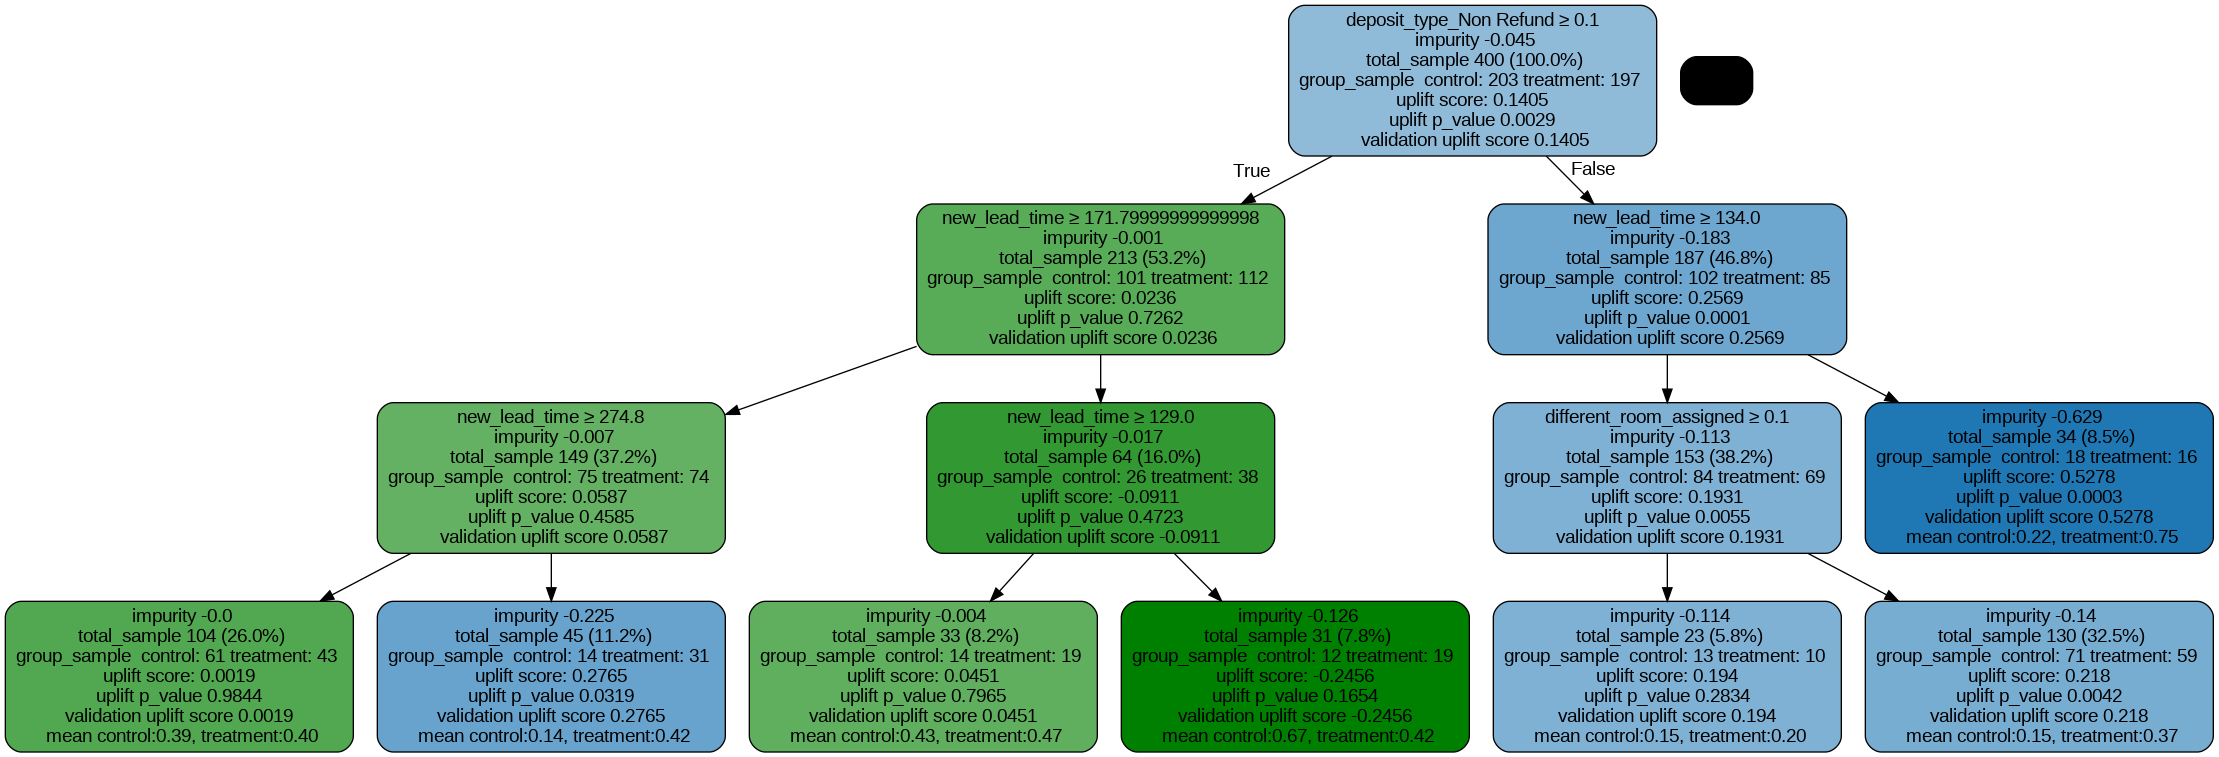

[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/uplift_tree.png
[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/uplift_tree.svg


In [10]:
# split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=111)

# specify columns to be used for training
x_names = ['previous_cancellations', 'total_of_special_requests',
           'different_room_assigned', 'required_car_parking_spaces',
           'previous_bookings_not_canceled', 'is_repeated_guest', 'country_PRT',
           'country_other', 'new_lead_time',
           'deposit_type_No Deposit', 'deposit_type_Non Refund',
           'deposit_type_Refundable', 'market_segment_Groups',
           'distribution_channel_Corporate', 'distribution_channel_Direct',
           'distribution_channel_TA/TO', 'hotel_City Hotel', 'hotel_Resort Hotel',
           'customer_type_Contract', 'customer_type_Transient',
           'customer_type_Transient-Party']

# Train uplift tree
uplift_model = UpliftTreeClassifier(
    max_depth = 4,
    min_samples_leaf = 20,
    min_samples_treatment = 10,
    n_reg = 0,
    evaluationFunction='KL',  # The Kullback-Leibler (KL) divergence
    control_name='control')

uplift_model.fit(df_train[x_names].values,
                 treatment=df_train['treatment_control'].values,
                 y=df_train['conversion'].values)


#uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)
# plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, x_names)
Image(graph.create_png())

# plot uplift tree and SAVE ONLY
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, x_names)
# ensure folder exists (usually already true)
os.makedirs(PLOTS_DIR, exist_ok=True)
display(Image(data=graph.create_png()))

# PNG
png_path = os.path.join(PLOTS_DIR, "uplift_tree.png")
with open(png_path, "wb") as f:
    f.write(graph.create_png())
print(f"[saved] {png_path}")

# nice for README
try:
    svg_path = os.path.join(PLOTS_DIR, "uplift_tree.svg")
    with open(svg_path, "wb") as f:
        f.write(graph.create_svg())
    print(f"[saved] {svg_path}")
except Exception:
    pass


**How to read each node**

- Split rule (top of box): e.g., deposit_type_Non Refund ≥ 0.1.
With one-hot dummies, ≥ 0.1 basically means that category = 1.
- impurity -  how similar treatment and control outcomes are inside the node
  -  High impurity → treatment and control have similar conversion rates (low uplift)
  - Low impurity → treatment and control have different conversion rates (high uplift)
- total_sample: rows in that node.
- group_sample control / treatment: counts per group.
- uplift score: (treated conversion - control conversion) in that node.
- uplift p_value: significance of that difference
- mean control / treatment: the actual conversion rates per group in that node.

## **What tree says (high level)**
Root: deposit_type_Non Refund ≥ 0.1 So the first split is “Non-Refund” vs everything else. (shows very low impurity, low p-value and uplift score of .14)

--- **Right branch (Non-Refund NO → Refundable/No-Deposit)** ----
Next split: new_lead_time ≥ 134.

Node (n=187): uplift ≈ +0.257, p ≈ 0.0001.
This segment is a strong “treat” candidate.

Then it splits on different_room_assigned ≥ 0.1:

Leaf (n=153): uplift ≈ +0.193 (steady, decent size).

Leaf (n=34): uplift is very large (looks ~+0.5 to +0.7 from the rates), but tiny sample → high variance and this feature may be post-treatment (consider dropping to avoid leakage - when is different room assigned?).

--- **Left branch (Non-Refund YES)** ---

new_lead_time thresholds (≈ 171.8 then 129):

Some children show small positive uplift (e.g., +0.024) so weak benefit and p-value is really high as well.

One child shows negative uplift (≈ -0.091, n=64) - do not treat that segment.

A couple of tiny leaves (n≈30- 45) show moderate positives; treat with caution due to size.

**Actionable rules from this tree (train-side)**

Treat: deposit_type != "Non Refund" AND new_lead_time ≥ 134 (esp. the large leaf, n=153, uplift about +0.19).

Avoid: deposit_type == "Non Refund" AND 129 ≤ new_lead_time < 171.8 (uplift negative)

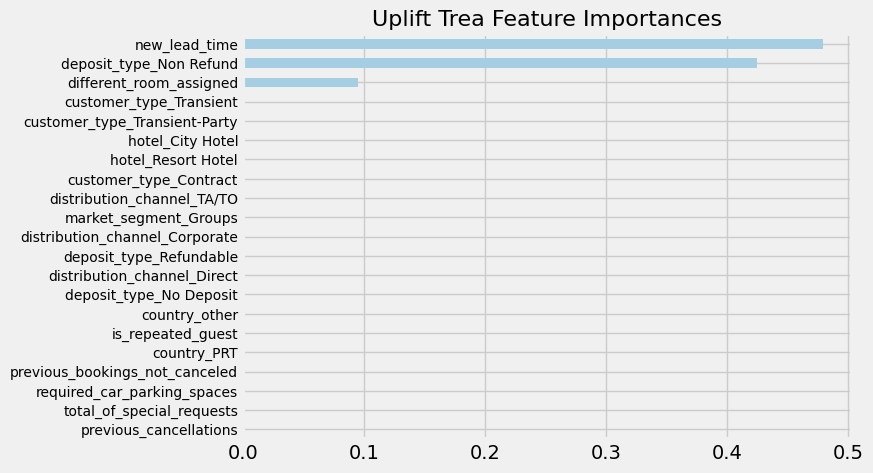

In [12]:
# uplift Tree Importances (Interpretable CausaML)
# pd.Series(uplift_model.feature_importances_, index=x_names).sort_values().plot(
#     kind='barh', figsize=(7,5))
ax = pd.Series(uplift_model.feature_importances_, index=x_names).sort_values().plot(
    kind='barh',
    figsize=(7, 5))
ax.set_title("Uplift Trea Feature Importances", fontsize=16)
ax.tick_params(axis='y', labelsize=10)

imp_png = os.path.join(PLOTS_DIR, "uplift_tree_importances.png")
fig = ax.get_figure()
fig.savefig(imp_png, bbox_inches='tight', dpi=300)

plt.show()

new_lead_time and deposit_type_Non Refund dominate (~0.45 each): the tree is mostly using these two to find segments where the offer changes conversion differently than in control.

different_room_assigned has a smaller signal; everything else ≈ 0: likely the tree reached depth quickly using the top 1-2 features, leaving little room for others.

Lead time and deposit type strongly relate to propensity to cancel and interact with the offer's effect.

**Lead time is actionable** - so lets explore that more.

#**S-LEARNER (LightGBM) + IMPORTANCE + SHAP PLOTS** - Interpretable CausaML

https://causalml.readthedocs.io/en/latest/methodology.html#s-learner

https://causalml.readthedocs.io/en/latest/interpretation.html

**Using S-learner for this case.**

Create an S-learner wrapper around a base classifier (LightGBM).

BaseSClassifier learns a single outcome model that predicts conversion probability given features x and treatment indicatort.

control_name='control' tells the wrapper which label in treatment_control column is the control group (everything else is treated).

***Why this method:***

S-learner is simple and strong for tabular data: one model learns both baseline risk and how treatment changes it.

LightGBM handles non-linearities & interactions (e.g., lead_time x deposit_type) and works well with one-hot features.

Compared to hand-built uplift trees, this can capture smooth heterogeneity and often ranks uplift better out-of-the-box.

In [11]:
#S-learner wrapper around a base classifier (LightGBM here)

slearner = BaseSClassifier(learner=LGBMClassifier(verbose=-1), control_name='control')

#Trains internally and estimates the Average Treatment Effect (ATE) on the given data.
slearner.estimate_ate(
    df_train[x_names].values, df_train['treatment_control'].values, df_train['conversion'].values,
    return_ci=True) # returns confidence interval
# tau - the condition average treatment effect
#fits the S-learner on the training data and returns row-level CATEs or uplift scores
# its like saying  “If this guest receives the offer, how much does their probability of not canceling increase vs. control?”
slearner_tau = slearner.fit_predict(
    df_train[x_names].values, df_train['treatment_control'].values, df_train['conversion'].values)

# Conditional Average Treatment Effects (CATE, denoted Tau) --- We can measure by person
len(slearner_tau)
slearner_tau[0:5]
#The way to read it... if its negative offer did not make an impact (or they were in the control group)... if it postive how much the offer helped in not canceling assuming they are among the once that accepted the offer

array([[ 0.00855878],
       [ 0.0277305 ],
       [ 0.35458116],
       [ 0.11206131],
       [-0.02936755]])

### Conditional Average Treatment Effects (CATE, denoted Tau) --- We can measure by person

The way to read it... if its negative offer did not make an impact (or they were in the control group)... if it postive how much the offer helped in not canceling assuming they are among the once that accepted the offer

[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/slearner_tau_importances.png


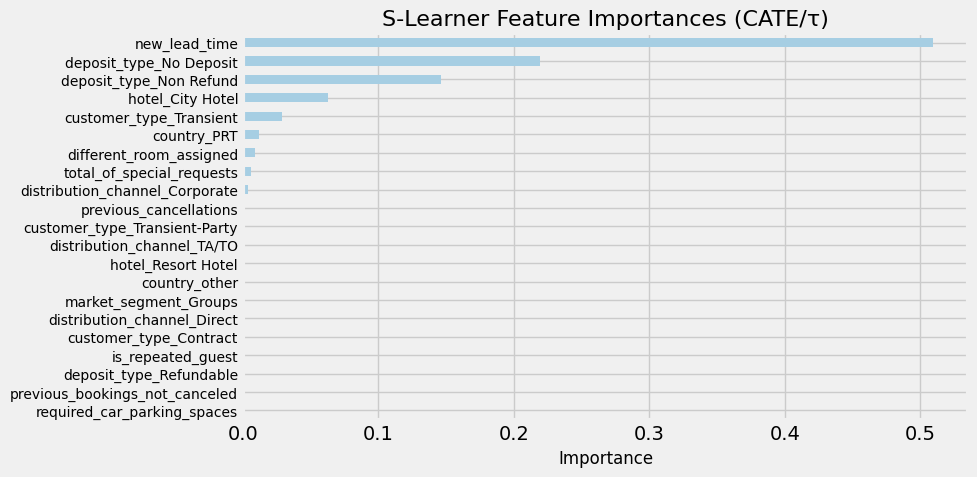

In [13]:
# feature importances from S-learner
imp_dict = slearner.get_importance(X=df_train[x_names].values, tau=slearner_tau, normalize=True,
    method='auto', features=x_names)

# extract the series from the 'treatment' key
imp_ser = imp_dict['treatment'].sort_values()

# plots
ax = imp_ser.plot(kind='barh', figsize=(10, 5))
ax.set_title("S-Learner Feature Importances (CATE/τ)", fontsize=16)
ax.set_xlabel("Importance", fontsize=12)
ax.set_ylabel("")
ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()

out_path = os.path.join(PLOTS_DIR, "slearner_tau_importances.png")
fig = ax.get_figure()
fig.savefig(out_path, bbox_inches='tight', dpi=300)
print(f"[saved] {out_path}")

plt.show()

S-learner importance = explains τ̂ tau from a flexible gradient-boosted model (global, smooth, captures interactions implicitly).

Feature importance for the predicted treatment effect (CATE, τ) from the S-learner. Higher bars = stronger drivers of how much the offer changes the keep-booking probability, not baseline conversion.

**Results**

Lead time is the strongest driver of uplift: guests with certain lead-time ranges respond most to the offer.

Deposit type matters: No-Deposit tends to increase uplift; Non-Refund tends to have lower uplift.

City-hotel stays show higher uplift than resort stays.
Together, these suggest prioritizing offers for refundable/no-deposit city-hotel bookings with the right lead-time window.

# **SHAP VALUES**

[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/slearner_shap_values.png


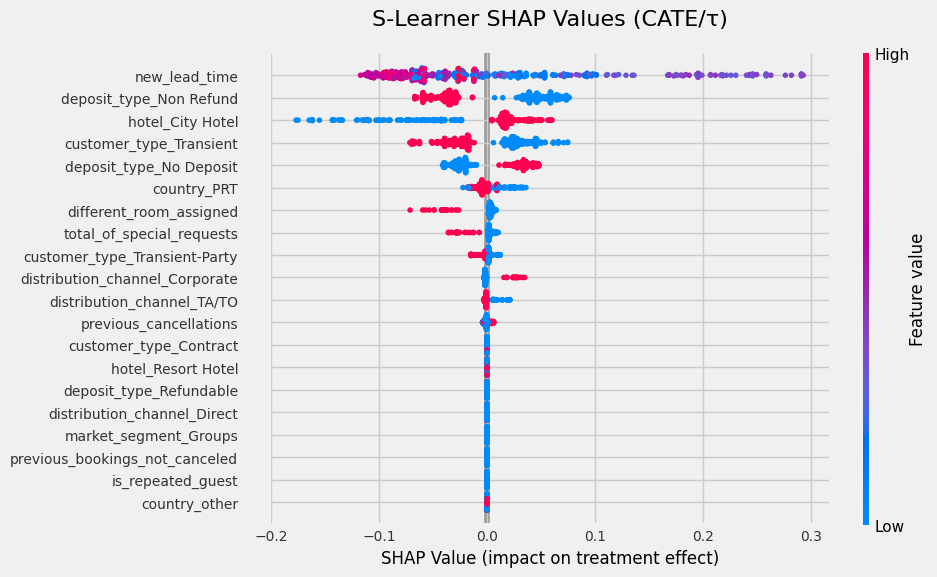

In [14]:
#SHAP values from S-learner
shap_dict = slearner.get_shap_values(X=df_train[x_names].values, tau=slearner_tau)

# extract SHAP values (likely under 'treatment' key like importances)
if isinstance(shap_dict, dict) and 'treatment' in shap_dict:
    shap_values = shap_dict['treatment']
else:
    shap_values = shap_dict

# create SHAP summary plot with custom styling
import shap

fig, ax = plt.subplots(figsize=(10, 6))

# SHAP summary plot (beeswarm/dot plot)
shap.summary_plot(
    shap_values,
    df_train[x_names].values,
    feature_names=x_names,
    show=False,
    plot_size=(10, 6)
)

ax = plt.gca()
ax.set_title("S-Learner SHAP Values (CATE/τ)", fontsize=16, pad=20)
ax.set_xlabel("SHAP Value (impact on treatment effect)", fontsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=10)

plt.tight_layout()

out_path = os.path.join(PLOTS_DIR, "slearner_shap_values.png")
plt.savefig(out_path, bbox_inches='tight', dpi=300)
print(f"[saved] {out_path}")

plt.show()

Each dot is individual row or booking. Each feature row in the SHAP represents all data points (500 rows). The features are automatically ordered by importance

Right of 0 = this feature pushes predicted uplift UP (offer helps more).
Left of 0 =  this feature pushes predicted uplift DOWN (offer helps less / may hurt).
Color (purple to pink): the feature value for that dot (not feature importance).
-  Blue / Purple	Low feature value (e.g., “small lead time” or “not that category”)
- Red / Pink	High feature value (e.g., “large lead time” or “is that category”)

**Basically if a feature shows a clear color separation, the color that sits mostly on the right identifies values associated with higher uplift.**

For this case:
new_lead_time- Even short-lead-time guests show some uplift — the model thinks the offer still helps some of them (color blue- purple for short lead time but high shap value). There is strong presence of purple with high shap which means for lead time that is in the middle treatment really helps. But when lead time is high the model shap is negative or less so it treatment offers little help.

deposit_type_Non Refund - Clear blue to the right (1 = Non-Refund bookings)and red to the left (0 = refundable (not Non-Refund)). If its refundable offer helps, if its not refundable offer doesn't help.
Matches the uplift tree — “Treat guests with refundable deposits; avoid treating non-refundable ones.”

hotel_City Hotel - red dot to the right (1) means guest staying in city hotels benefit from the treatment, but when they are not staying in the hotels the treatment doesn't help.


[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/slearner_shap_dependence_new_lead_time.png


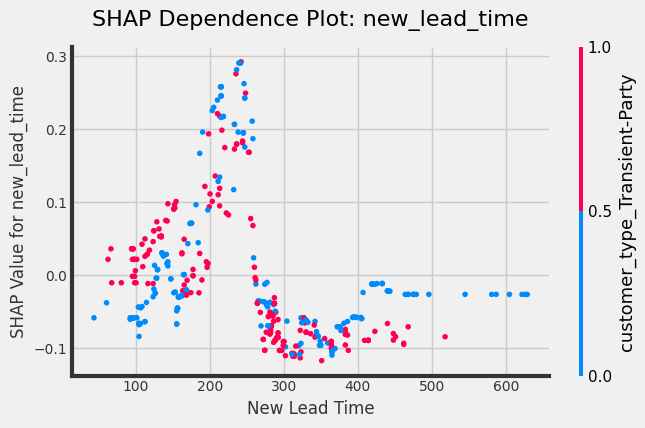

In [15]:
# feature to analyze
feature_name = 'new_lead_time'
feature_idx = x_names.index(feature_name)

# SHAP values
shap_dict = slearner.get_shap_values(X=df_train[x_names].values, tau=slearner_tau)
shap_values = shap_dict['treatment'] if isinstance(shap_dict, dict) else shap_dict

# SHAP dependence plot with custom styling
import shap

fig, ax = plt.subplots(figsize=(7, 4.5))

# SHAP dependence plot
shap.dependence_plot(
    feature_idx,
    shap_values,
    df_train[x_names].values,
    feature_names=x_names,
    interaction_index='auto',
    show=False,
    ax=ax
)

# customize the plot
ax.set_title(f"SHAP Dependence Plot: {feature_name}", fontsize=16, pad=15)
ax.set_xlabel(feature_name.replace('_', ' ').title(), fontsize=12)
ax.set_ylabel(f"SHAP Value for {feature_name}", fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()

#
out_path = os.path.join(PLOTS_DIR, f"slearner_shap_dependence_{feature_name}.png")
plt.savefig(out_path, bbox_inches='tight', dpi=300)
print(f"[saved] {out_path}")

plt.show()

In [16]:
print(20, x_names[20])

20 customer_type_Transient-Party


dependence plot showing how SHAP values (the contribution to uplift) change with the actual value of new_lead_time.
Each dot = one booking.
X-axis: actual lead time value.
Y-axis: SHAP value - how much that specific lead time increased or decreased predicted uplift.

Color bar (Feature_020): the interaction feature that most strongly interacts with new_lead_time — LightGBM found that “Feature_020 which is customer_type_Transient-Party” changes the shape of the relationship.

**Feature: new_lead_time (customer_type_Transient-Party)**  
- Mid-range lead times (150-250 days) show the highest SHAP values(0.3), meaning the offer significantly increases conversion for these guests.  
- Short lead times (<100 days) show little effect.  
- Long lead times (>300 days) yield low or negative SHAP, suggesting no added benefit.  
- Color pattern: blue (non-Transient-Party) bookings drive most of the uplift, while red (Transient-Party) bookings show slighly weaker or neutral effects.
→ Treat guests who are not Transient-Party and book 150-250 days ahead; avoid heavy focus on Transient-Party segments.


[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/slearner_shap_dependence_deposit_non_refund.png


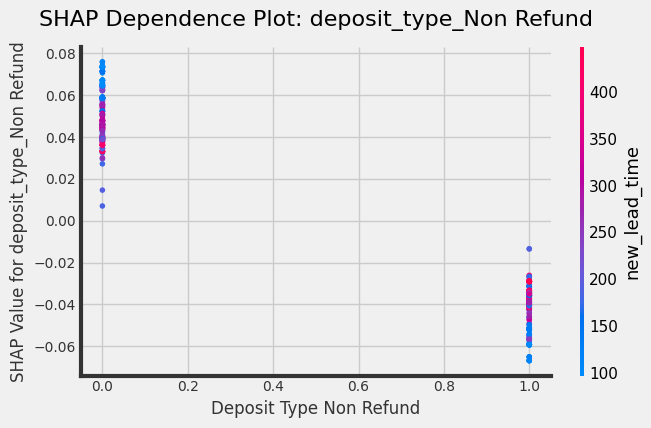

In [17]:
# feature to analyze
feature_name = 'deposit_type_Non Refund'
feature_idx = x_names.index(feature_name)

fig, ax = plt.subplots(figsize=(7, 4.5))

# SHAP dependence plot
shap.dependence_plot(
    feature_idx,
    shap_values,
    df_train[x_names].values,
    feature_names=x_names,
    interaction_index='auto',
    show=False,
    ax=ax
)

# Customize the plot
ax.set_title(f"SHAP Dependence Plot: {feature_name}", fontsize=16, pad=15)
ax.set_xlabel(feature_name.replace('_', ' ').title(), fontsize=12)
ax.set_ylabel(f"SHAP Value for {feature_name}", fontsize=12)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()

# Save the figure
out_path = os.path.join(PLOTS_DIR, f"slearner_shap_dependence_deposit_non_refund.png")
plt.savefig(out_path, bbox_inches='tight', dpi=300)
print(f"[saved] {out_path}")

plt.show()

In [17]:
print(8, x_names[8])

8 new_lead_time


**Feature: deposit_type_Non Refund (colored by new_lead_time)**

x=0 (NOT Non-Refund; i.e., Refundable/No-Deposit): SHAP values are positive (0.02-0.08) = this feature pushes uplift up for these bookings.

x=1 (Non-Refund): SHAP values are mostly negative (-0.06 to 0.00) = being Non-Refund reduces uplift.

Color pattern (lead time): Dots at both x=0 and x=1 span the full lead-time range (blue- pink), but the sign stays consistent: refundable tends to increase uplift, non-refund tends to decrease uplift across lead times.

**Favor offers for refundable/no-deposit bookings; avoid non-refund bookings, regardless of lead time.**

#** UPLIFT EVALUATION: Uplift@K + Qini/AUUC**


Train size: 400 | Test size: 100
Train treatment rate: 49.25% | Test treatment rate: 53.00%

Training T-Learner models...
Control model trained on 203 samples
Treatment model trained on 197 samples

Uplift scores: min=-0.9516, max=0.9578, mean=0.1168

------------------------------------------------------------
UPLIFT@K METRICS (Top K% by predicted uplift)
Uplift@10%: +0.2000  (T=5, C=5)
Uplift@20%: +0.1667  (T=12, C=8)
Uplift@30%: +0.0278  (T=18, C=12)
Uplift@40%: -0.0025  (T=21, C=19)
Uplift@50%: +0.0417  (T=26, C=24)
Uplift@60%: +0.0471  (T=33, C=27)
Uplift@70%: +0.1261  (T=37, C=33)
Uplift@80%: +0.0840  (T=42, C=38)
Uplift@90%: +0.0711  (T=46, C=44)

------------------------------------------------------------
QINI / AUUC CALCULATION
Treatment probability in test set: 0.530
AUUC (Area Under Uplift Curve): 4.35
Higher is better (more lift from targeting high-uplift customers)

[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/qini_auuc_

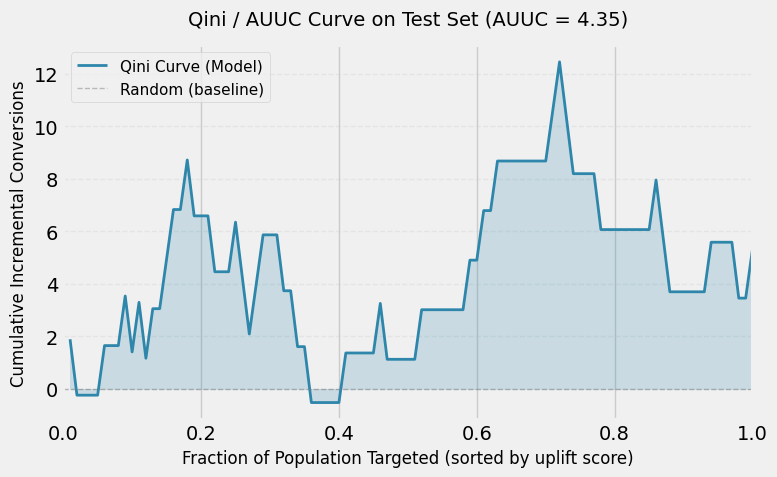

In [19]:
# UPLIFT EVALUATION: Uplift@K + Qini/AUUC
# dATA
Xtr = df_train[x_names].values
ttr = (df_train['treatment_control'] == 'treatment').astype(int)  # 1=treatment, 0=control
ytr = df_train['conversion'].values.astype(int)

Xte = df_test[x_names].values
tte = (df_test['treatment_control'] == 'treatment').astype(int)
yte = df_test['conversion'].values.astype(int)

print(f"\nTrain size: {len(Xtr):,} | Test size: {len(Xte):,}")
print(f"Train treatment rate: {ttr.mean():.2%} | Test treatment rate: {tte.mean():.2%}")

# FIT T-LEARNER (SEPARATE MODELS PER ARM)
print("\nTraining T-Learner models...")
lgb_params = {'verbose': -1, 'n_estimators': 600, 'learning_rate': 0.05, 'num_leaves': 63,
    'min_data_in_leaf': 10, 'subsample': 0.9, 'subsample_freq': 1,'random_state': 42}

# Control model (trained on control group)
mdl_c = LGBMClassifier(**lgb_params)
mdl_c.fit(Xtr[ttr == 0], ytr[ttr == 0])

# treatment model (trained on treatment group)
mdl_t = LGBMClassifier(**lgb_params)
mdl_t.fit(Xtr[ttr == 1], ytr[ttr == 1])

print(f"Control model trained on {(ttr == 0).sum():,} samples")
print(f"Treatment model trained on {(ttr == 1).sum():,} samples")

# PREDICT POTENTIAL OUTCOMES ON TEST SET
y0 = mdl_c.predict_proba(Xte)[:, 1]  # P(convert | control)
y1 = mdl_t.predict_proba(Xte)[:, 1]  # P(convert | treatment)
uplift_score = y1 - y0

print(f"\nUplift scores: min={uplift_score.min():.4f}, max={uplift_score.max():.4f}, mean={uplift_score.mean():.4f}")

# BUILD EVALUATION DATAFRAME (SORTED BY UPLIFT)
df_eval = pd.DataFrame({
    't': tte,# Actual treatment indicator (1=treatment, 0=control)
    'y': yte,# Observed conversion (1=converted, 0=cancelled)
    'score': uplift_score# Predicted uplift
}).sort_values('score', ascending=False).reset_index(drop=True)

# CALCULATE UPLIFT@K METRICS
def uplift_at_fraction(df_sorted, frac):
    """
    Calculate uplift at top K% of population.
    Uplift = conversion rate (treatment) - conversion rate (control) in top K%.
    """
    k = max(1, int(frac * len(df_sorted)))
    top_k = df_sorted.head(k)

    # Calculate conversion rates for each arm
    treated = top_k[top_k['t'] == 1]
    control = top_k[top_k['t'] == 0]

    rate_t = treated['y'].mean() if len(treated) > 0 else 0.0
    rate_c = control['y'].mean() if len(control) > 0 else 0.0

    # Return uplift and sample counts for diagnostics
    return rate_t - rate_c, len(treated), len(control)

print("\n" + "-" * 60)
print("UPLIFT@K METRICS (Top K% by predicted uplift)")

fractions = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
uplift_at_k = {}

for frac in fractions:
    uplift, n_treat, n_control = uplift_at_fraction(df_eval, frac)
    uplift_at_k[frac] = uplift
    print(f"Uplift@{int(frac*100):2d}%: {uplift:+.4f}  (T={n_treat:,}, C={n_control:,})")

# CALCULATE QINI / AUUC CURVE
print("\n" + "-" * 60)
print("QINI / AUUC CALCULATION")


# Empirical treatment probability (should be ~0.5 for A/B test)
p = df_eval['t'].mean()
print(f"Treatment probability in test set: {p:.3f}")

# Cumulative counts
df_eval['cum_t'] = df_eval['t'].cumsum()
df_eval['cum_c'] = (1 - df_eval['t']).cumsum()
df_eval['cum_y_t'] = (df_eval['y'] * df_eval['t']).cumsum()
df_eval['cum_y_c'] = (df_eval['y'] * (1 - df_eval['t'])).cumsum()

# Cumulative incremental conversions (scaled by treatment probability)
eps = 1e-9
uplift_cum = (df_eval['cum_y_t'] / max(p, eps) -
              df_eval['cum_y_c'] / max(1 - p, eps))

# Calculate AUUC (Area Under Uplift Curve) using trapezoidal rule
x = np.arange(1, len(df_eval) + 1) / len(df_eval)
auuc = np.trapz(uplift_cum, x)

print(f"AUUC (Area Under Uplift Curve): {auuc:.2f}")
print(f"Higher is better (more lift from targeting high-uplift customers)")

# PLOT QINI / AUUC CURVE
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(x, uplift_cum, linewidth=2, color='#2E86AB', label='Qini Curve (Model)')
ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Random (baseline)')
ax.fill_between(x, 0, uplift_cum, alpha=0.2, color='#2E86AB')

ax.set_xlabel('Fraction of Population Targeted (sorted by uplift score)', fontsize=12)
ax.set_ylabel('Cumulative Incremental Conversions', fontsize=12)
ax.set_title(f'Qini / AUUC Curve on Test Set (AUUC = {auuc:.2f})', fontsize=14, pad=15)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend(fontsize=11)
ax.set_xlim(0, 1)

plt.tight_layout()

#plot
os.makedirs(PLOTS_DIR, exist_ok=True)
qini_path = os.path.join(PLOTS_DIR, "qini_auuc_curve.png")
plt.savefig(qini_path, dpi=250, bbox_inches='tight')
print(f"\n[saved] {qini_path}")

plt.show()


The Qini curve shows strong uplift among the top 10-30% of customers, confirming the model successfully identifies high-impact guests who respond well to the offer.

After that, uplift flattens, suggesting diminishing returns when targeting broader segments. A smaller secondary rise around the 60% mark may indicate an additional niche segment that benefits from the offer, though this pattern could also reflect noise due to small sample size.

Overall, the positive AUUC and early sharp lift demonstrate that the model provides clear value over random targeting, helping prioritize the most responsive customers for discount offers.

Signal is strongest early. Top 10-20% are clear wins ( +20pp, +16.7pp uplift).  Core targeting band.

Beyond 30%, uplift gets noisy: it dips (-0.25pp at 40%) then recovers and stays modestly positive through 90% (peaks again around 70%: +12.6pp).

AUUC = 4.35 > 0 confirms the model beats random overall.

..............  ..................  ................

The x-axis is the fraction of population targeted (sorted by model uplift score).

The y-axis is the total incremental conversions gained up to that fraction. It shows how much extra conversion (vs control) generated by targeting up to that percentage.

-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
#**CORE CAUSAL ESTIMANDS (ITT, CACE/LATE, Value-ITT w/ CI)**

###ITT = Intent-to-Treat

- ITT (cancellation + conversion) with 95% CI

- CACE / LATE (Wald IV) with bootstrap 95% CI

- Value-ITT (mean $ per assigned guest, treat - control) + bootstrap 95% CI + plot

CAUSAL INFERENCE: EXPERIMENTAL RESULTS
......................................................................
1. ITT (INTENT-TO-TREAT) EFFECTS
......................................................................

Sample sizes: Treatment=250, Control=250

Conversion rates: Treatment=0.420, Control=0.296
ITT (conversion): +0.124  (95% CI: +0.041, +0.207)

Cancellation rates: Treatment=0.580, Control=0.704
ITT (cancellation): -0.124  (95% CI: -0.207, -0.041)
2. CACE / LATE (EFFECT ON COMPLIERS)
......................................................................

First-stage (compliance): 0.248
CACE (effect among compliers): +0.500
CACE 95% CI (bootstrap): +0.162, +0.814  (B=3000)
3. VALUE-ITT ($ PER ASSIGNED GUEST)
......................................................................

Value-ITT: $123.00 per assigned guest
95% CI: $5.40, $240.00
CREATING VISUALIZATIONS
......................................................................

[saved] /content/drive/MyDrive/masters_math/

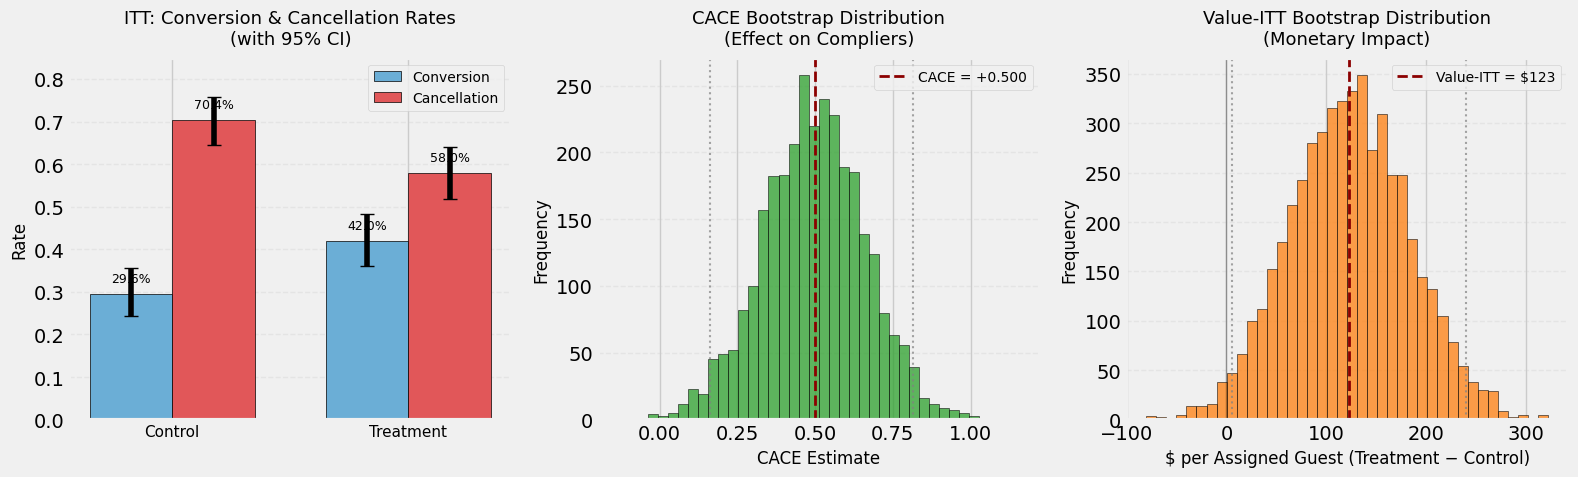

In [20]:
# CORE CAUSAL ESTIMANDS: ITT, CACE, VALUE-ITT

print("CAUSAL INFERENCE: EXPERIMENTAL RESULTS")
print("." * 70)

df = hotel_experiment_df.copy()

# 1. ITT (INTENT-TO-TREAT) ANALYSIS

print("1. ITT (INTENT-TO-TREAT) EFFECTS")
print("." * 70)

# Group sizes
g = df.groupby('treatment_control', observed=True)
n_t = g.size().get('treatment', 0)
n_c = g.size().get('control', 0)

# Outcomes
conv_t = (df.loc[df.treatment_control == 'treatment', 'is_canceled'] == 0).sum()
conv_c = (df.loc[df.treatment_control == 'control', 'is_canceled'] == 0).sum()
cancel_t = (df.loc[df.treatment_control == 'treatment', 'is_canceled'] == 1).sum()
cancel_c = (df.loc[df.treatment_control == 'control', 'is_canceled'] == 1).sum()

# Rates
pconv_t = conv_t / n_t
pconv_c = conv_c / n_c
pcxl_t = cancel_t / n_t
pcxl_c = cancel_c / n_c

# ITT effects
itt_conv = pconv_t - pconv_c
itt_cxl = pcxl_t - pcxl_c

# 95% CIs for ITT (using normal approximation for difference in proportions)
se_conv = np.sqrt(pconv_t * (1 - pconv_t) / n_t + pconv_c * (1 - pconv_c) / n_c)
se_cxl = np.sqrt(pcxl_t * (1 - pcxl_t) / n_t + pcxl_c * (1 - pcxl_c) / n_c)

conv_ci_lo = itt_conv - 1.96 * se_conv
conv_ci_hi = itt_conv + 1.96 * se_conv
cxl_ci_lo = itt_cxl - 1.96 * se_cxl
cxl_ci_hi = itt_cxl + 1.96 * se_cxl

print(f"\nSample sizes: Treatment={n_t}, Control={n_c}")
print(f"\nConversion rates: Treatment={pconv_t:.3f}, Control={pconv_c:.3f}")
print(f"ITT (conversion): {itt_conv:+.3f}  (95% CI: {conv_ci_lo:+.3f}, {conv_ci_hi:+.3f})")
print(f"\nCancellation rates: Treatment={pcxl_t:.3f}, Control={pcxl_c:.3f}")
print(f"ITT (cancellation): {itt_cxl:+.3f}  (95% CI: {cxl_ci_lo:+.3f}, {cxl_ci_hi:+.3f})")


# 2. CACE / LATE (COMPLIER EFFECT)
print("2. CACE / LATE (EFFECT ON COMPLIERS)")
print("." * 70)

# Instrument Z = assignment, Treatment D = accept_offer, Outcome Y = kept booking
Z = (df['treatment_control'] == 'treatment').astype(int).values
D = df['accept_offer'].astype(int).values
Y = (1 - df['is_canceled'].astype(int)).values

# First stage (compliance rate)
pD1 = D[Z == 1].mean()
pD0 = D[Z == 0].mean()
first_stage = pD1 - pD0

# Wald estimator (CACE)
EY1 = Y[Z == 1].mean()
EY0 = Y[Z == 0].mean()
cace = (EY1 - EY0) / first_stage

print(f"\nFirst-stage (compliance): {first_stage:.3f}")
print(f"CACE (effect among compliers): {cace:+.3f}")

# Bootstrap CI for CACE
rng = np.random.default_rng(42)
B = 3000
cace_draws = []
n = len(df)

for _ in range(B):
    idx = rng.integers(0, n, n)
    Zi, Di, Yi = Z[idx], D[idx], Y[idx]
    fs = Di[Zi == 1].mean() - Di[Zi == 0].mean()
    if fs > 0:
        cace_draws.append((Yi[Zi == 1].mean() - Yi[Zi == 0].mean()) / fs)

cace_lo, cace_hi = np.percentile(cace_draws, [2.5, 97.5])
print(f"CACE 95% CI (bootstrap): {cace_lo:+.3f}, {cace_hi:+.3f}  (B={len(cace_draws)})")

# =========================================
# 3. VALUE-ITT (MONETARY IMPACT)
# =========================================
print("3. VALUE-ITT ($ PER ASSIGNED GUEST)")
print("." * 70)

V, C = 1500, 150  # booking value, discount cost

# Realized value per guest
val = np.where(
    df['treatment_control'] == 'treatment',
    (1 - df['is_canceled'].astype(int)) * (V - C),  # Treated & kept: $1350
    (1 - df['is_canceled'].astype(int)) * V          # Control & kept: $1500
)

val_t = val[df['treatment_control'] == 'treatment']
val_c = val[df['treatment_control'] == 'control']
value_itt = val_t.mean() - val_c.mean()

# Bootstrap CI for Value-ITT
rng = np.random.default_rng(123)
B = 5000
value_draws = []

for _ in range(B):
    vt = rng.choice(val_t, size=len(val_t), replace=True).mean()
    vc = rng.choice(val_c, size=len(val_c), replace=True).mean()
    value_draws.append(vt - vc)

val_lo, val_hi = np.percentile(value_draws, [2.5, 97.5])

print(f"\nValue-ITT: ${value_itt:.2f} per assigned guest")
print(f"95% CI: ${val_lo:.2f}, ${val_hi:.2f}")


# 4. CREATE SIDE-BY-SIDE PLOTS
print("CREATING VISUALIZATIONS")
print("." * 70)

os.makedirs(PLOTS_DIR, exist_ok=True)

# Create 1x3 side-by-side plot
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

#  PLOT 1: ITT RATES BY ARM
ax = axes[0]

# Wilson CIs for each arm
conv_lo_t, conv_hi_t = proportion_confint(conv_t, n_t, method="wilson")
conv_lo_c, conv_hi_c = proportion_confint(conv_c, n_c, method="wilson")
cxl_lo_t, cxl_hi_t = proportion_confint(cancel_t, n_t, method="wilson")
cxl_lo_c, cxl_hi_c = proportion_confint(cancel_c, n_c, method="wilson")

labels = ["Control", "Treatment"]
conv_rates = [pconv_c, pconv_t]
conv_err = [
    [pconv_c - conv_lo_c, pconv_t - conv_lo_t],
    [conv_hi_c - pconv_c, conv_hi_t - pconv_t]
]
cxl_rates = [pcxl_c, pcxl_t]
cxl_err = [
    [pcxl_c - cxl_lo_c, pcxl_t - cxl_lo_t],
    [cxl_hi_c - pcxl_c, cxl_hi_t - pcxl_t]
]

x = np.arange(len(labels))
w = 0.35

b1 = ax.bar(x - w/2, conv_rates, width=w, label="Conversion",
            color="#6baed6", edgecolor="black", yerr=conv_err, capsize=5)
b2 = ax.bar(x + w/2, cxl_rates, width=w, label="Cancellation",
            color="#e15759", edgecolor="black", yerr=cxl_err, capsize=5)

ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylabel("Rate", fontsize=12)
ax.set_title("ITT: Conversion & Cancellation Rates\n(with 95% CI)", fontsize=13, pad=10)
ax.set_ylim(0, 0.85)
ax.grid(axis="y", linestyle="--", alpha=0.3)
ax.legend(fontsize=10)

# Annotate percentages
for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02,
                f"{h:.1%}", ha="center", va="bottom", fontsize=9)

# plot 2: CACE BOOTSTRAP DISTRIBUTION
ax = axes[1]

ax.hist(cace_draws, bins=40, alpha=0.75, color="#2ca02c", edgecolor="black")
ax.axvline(cace, color='darkred', linestyle='--', linewidth=2,
           label=f"CACE = {cace:+.3f}")
ax.axvline(cace_lo, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axvline(cace_hi, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)

ax.set_xlabel("CACE Estimate", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("CACE Bootstrap Distribution\n(Effect on Compliers)", fontsize=13, pad=10)
ax.legend(fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.3)

# PLOT 3: VALUE-ITT BOOTSTRAP DISTRIBUTION
ax = axes[2]

ax.hist(value_draws, bins=40, alpha=0.75, color="#ff7f0e", edgecolor="black")
ax.axvline(value_itt, color='darkred', linestyle='--', linewidth=2,
           label=f"Value-ITT = ${value_itt:.0f}")
ax.axvline(val_lo, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axvline(val_hi, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)

ax.set_xlabel("$ per Assigned Guest (Treatment − Control)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Value-ITT Bootstrap Distribution\n(Monetary Impact)", fontsize=13, pad=10)
ax.legend(fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()

# save
path = os.path.join(PLOTS_DIR, "causal_estimands_summary.png")
plt.savefig(path, dpi=300, bbox_inches='tight')
print(f"\n[saved] {path}")

plt.show()

###**ITT = Intent-to-Treat**

###**Conversion ITT = P(kept | assigned treatment) − P(kept | assigned control)**
Each pair of bars shows the conversion rate (blue) and cancellation rate (red)
for the control vs treatment groups — with 95% confidence intervals (black lines)

Conversions (kept bookings) went up by (42.0% - 29.6%) 12.4 percentage points,

Cancellations went down by (58.0% - 70.4%) 12.4 percentage points,
and both differences are statistically significant since the error bars don't overlap much.



###**CACE (Complier Average Causal Effect)**

CACE of +0.50, meaning - compliers kept their bookings 50 percentage points more often than they would have if not offered.

Among people who actually accepted because they got the offer, how much more likely were they to keep their booking?

- bootstrap resampling (3,000 draws) to see how stable that estimate is.

The 95 % CI (+0.162, +0.814) shows uncertainty but stays positive—strong evidence of improvement.

This means guests who accepted the offer because they received it were about 50 percentage points more likely to keep their bookings, showing a strong causal lift among compliers.


###**Value-ITT Bootstrap Distribution**

ITT =  difference in outcomes between everyone assigned to treatment vs control.

Bootstrapped it — resampled 1000+ times, recalculating that mean difference each time.

**result**

The entire curve sits mostly above zero, so confident the offer increased value on average.

The mean gain is \$123 per assigned guest, with 95% CI - plausible values between \$5 and $240.

bootstrap distribution of the Value-ITT estimate

#**ROI**

accept_rate_treat: 0.248 ---- # 24.8% of targeted guests accepted the offer.
cancel_rate_accepted: 0.1774193548387097 ---- # Among acceptors, 17.7% still canceled.
kept_bookings: 51 ---- # Net kept bookings from the offer: 51.
expected_revenue: 68850 ---- # Revenue generated from kept bookings (after 10% discount).
lost_revenue_from_cancels: 16500 ---- # Revenue lost from cancellations among acceptors/treatment converts.
discount_cost_on_kept: 7650 ---- # Discount cost actually granted on kept bookings.
net_revenue_per_customer_targeted: 178.8 ---- Net value per targeted customer: $178.80.
estimated_roi: $3,542,207 ---- taken out of net dollars per targeted (after all adds/subtracts). Assuming 24.8% acceptance rate.
Scaling to 19,811 similar customers yields ≈ $3,542,206.80 in projected value.
-----------------------------------------------------------------------------------------------
 
[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/o

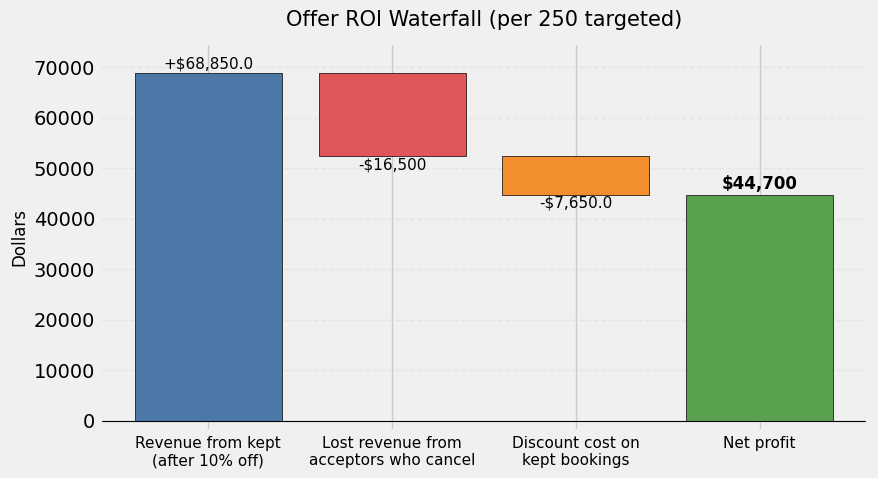

In [21]:
os.makedirs(PLOTS_DIR, exist_ok=True)

average_spend = 1500
discount_to_book_90_days_out = 0.10
acceptances = 62
cancels_among_accepted = 11
targeted = 250
population = 19811

# calcs
accept_rate_treat= acceptances / targeted
cancel_rate_accepted = cancels_among_accepted / acceptances
kept_bookings = acceptances - cancels_among_accepted
net_price = average_spend * (1 - discount_to_book_90_days_out)

expected_revenue = kept_bookings * net_price # +$68,850
lost_revenue_cancels = cancels_among_accepted * average_spend # -$16,500
discount_cost_on_kept = kept_bookings * average_spend * discount_to_book_90_days_out  # -$7,650
net_total = expected_revenue - lost_revenue_cancels - discount_cost_on_kept  # $44,700

net_revenue_per_targeted = net_total / targeted
estimated_roi = population * net_revenue_per_targeted

#
print(f"accept_rate_treat: {accept_rate_treat} ---- # 24.8% of targeted guests accepted the offer.")
print(f"cancel_rate_accepted: {cancel_rate_accepted} ---- # Among acceptors, 17.7% still canceled.")
print(f"kept_bookings: {kept_bookings} ---- # Net kept bookings from the offer: 51.")
print(f"expected_revenue: {int(expected_revenue)} ---- # Revenue generated from kept bookings (after 10% discount).")
print(f"lost_revenue_from_cancels: {int(lost_revenue_cancels)} ---- # Revenue lost from cancellations among acceptors/treatment converts.")
print(f"discount_cost_on_kept: {int(discount_cost_on_kept)} ---- # Discount cost actually granted on kept bookings.")
print(f"net_revenue_per_customer_targeted: {round(net_revenue_per_targeted, 2)} ---- Net value per targeted customer: $178.80.")
print(f"estimated_roi: ${estimated_roi:,.0f} ---- taken out of net dollars per targeted (after all adds/subtracts). Assuming 24.8% acceptance rate.")
print(f"Scaling to {population:,} similar customers yields ≈ ${estimated_roi:,.2f} in projected value.")
print(f"-----------------------------------------------------------------------------------------------")
print(f" ")


#waterfall plots
steps = [
    ("Revenue from kept\n(after 10% off)", expected_revenue),
    ("Lost revenue from\nacceptors who cancel", -lost_revenue_cancels),
    ("Discount cost on\nkept bookings", -discount_cost_on_kept),]
cum = [0]
for _, v in steps:
    cum.append(cum[-1] + v)
base = np.array(cum[:-1])
vals = np.array([v for _, v in steps])

fig, ax = plt.subplots(figsize=(9, 5))
colors = ['#4C78A8', '#E15759', '#F28E2B']  # pos, loss, cost

# bars for each step (stacked from running base)
bars = ax.bar(range(len(steps)), np.abs(vals), bottom=np.minimum(base, base + vals),
    color=colors, edgecolor='black')

# final NET bar — filled & labeled
net_color = '#59A14F'
net_bar = ax.bar([len(steps)], [net_total], bottom=0,
    color=net_color, edgecolor='black',label='Net profit')

# annotate intermediate bars
for (label, val), b in zip(steps, bars):
    y_text = (b.get_y() + b.get_height()) if val >= 0 else b.get_y()
    ax.text(
        b.get_x() + b.get_width()/2,
        y_text + (200 if val >= 0 else -200),
        f"{'+' if val>=0 else '-'}${abs(val):,}",
        ha='center', va='bottom' if val>=0 else 'top', fontsize=11)

# annotate NET bar (bold)
b = net_bar.patches[0]
ax.text(b.get_x() + b.get_width()/2, b.get_height() + 400,
    f"${net_total:,.0f}",ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# pretty axes
ax.set_xticks(range(len(steps)+1))
ax.set_xticklabels([s[0] for s in steps] + ["Net profit"], fontsize=11)
ax.set_ylabel("Dollars", fontsize=12)
ax.set_title("Offer ROI Waterfall (per 250 targeted)", fontsize=15, pad=12)
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# headers
ymax = max(cum + [net_total]) if net_total > 0 else max(cum)
ax.set_ylim(min(0, min(cum) - 2000), ymax + 6000)

plt.tight_layout()
wf_path = os.path.join(PLOTS_DIR, "offer_roi_waterfall.png")
plt.savefig(wf_path, dpi=240, bbox_inches='tight')
print(f"[saved] {wf_path}")
plt.show()


kept revenue = Money actually collect from acceptors (treatment concert) who kept their booking at the discounted price.

discount cost = Revenue that was used by discounting the kept bookings. 150 * # convert

lost revenue = treatment who still cancelled

Net = gross dollars collected minus discount dollars given and revenue lost from acceptor-cancels

# * Optimize for Conversion ---- For Policy
https://github.com/uber/causalml/blob/master/docs/examples/counterfactual_value_optimization.ipynb

# **Build a T-learner policy (trains two models: one for control, one for treatment)**


Using LightGBM for both arms handles non-linearities and interactions in tabular data.

Why: T-learner is a strong baseline for counterfactual prediction (what would happen under each arm).

[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/value_distribution.png


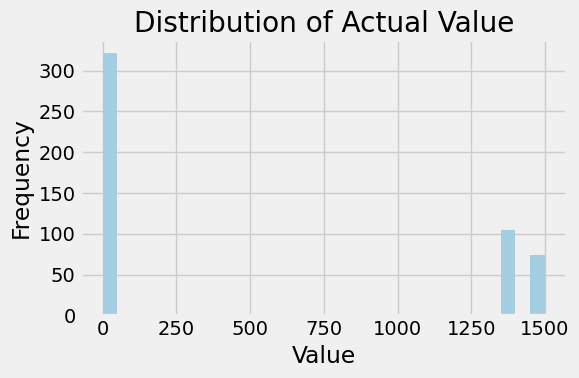

In [22]:
# costs: discount only if conversion happens
conversion_cost_dict = {'control': 0, 'treatment': 150}  # 10% of 1500 - extra cost to incur only if a conversion happens
impression_cost_dict = {'control': 0, 'treatment': 0} # the cost of showing the offer regardless of outcome (e.g., sending a voucher or email

# vectorized costs
#function to put treatment costs to array - downstream value functions expect vectorized costs that line up with each row
cc_array, ic_array, conditions = get_treatment_costs(
    treatment=df_processed['treatment_control'],
    control_name='control',
    cc_dict=conversion_cost_dict,
    ic_dict=impression_cost_dict)

# per-row conversion value ($1,500 per kept booking)
conversion_value_array = np.full(df_processed.shape[0], 1500)

# realized (off-policy) actual value from the A/B
actual_value = get_actual_value(
    treatment=df_processed['treatment_control'],
    observed_outcome=df_processed['conversion'],
    conversion_value=conversion_value_array,
    conditions=conditions,
    conversion_cost=cc_array,
    impression_cost=ic_array,)

plt.figure(figsize=(6,4)) # plot
plt.hist(actual_value, bins=30)
plt.title("Distribution of Actual Value")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()

os.makedirs(PLOTS_DIR, exist_ok=True)
out_path = os.path.join(PLOTS_DIR, "value_distribution.png")
plt.savefig(out_path, dpi=200, bbox_inches='tight')
print(f"[saved] {out_path}")
plt.show()


One is for 0 to indicate the number price spent on non-conversions (because impression cost is 0). Frequency = over 300

The other bins around 1350 - 1500.
- Control conversion: 1500 Frequency around 75
- Treatment conversion: 1500 - 150 = 1350 Frequency around 100

Takeaway: per-row value is highly skewed: lots of zeros, some large positives.

# A/B TEST
**Baseline: If treatment was assigned arms at random (as in an A/B test)**

In [23]:
# train/test split for policy evaluation
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=111)
train_idx, test_idx = df_train.index, df_test.index

# baseline 1 random allocation (mean value on test)
random_allocation_value = actual_value.loc[test_idx].mean()

# baseline 2 “best arm overall” by ATE on TRAIN, evaluated unbiasedly on TEST
best_ate_arm = df_train.groupby('treatment_control')['conversion'].mean().idxmax()
actual_is_best_ate = (df_test['treatment_control'] == best_ate_arm)
best_ate_value = actual_value.loc[test_idx][actual_is_best_ate].mean()

print("Random allocation value:", round(random_allocation_value, 2))
print("Best ATE value:", round(best_ate_value, 2))


Random allocation value: 552.0
Best ATE value: 560.38


#**T-learner policy (choose per row) + comparison plot**
T-learner: two separate LightGBM classifiers — one models the outcome under control, the other under treatment.

**“If we had to choose who to treat (show the offer) vs not treat, which strategy makes us the most money / prevents the most cancels?”**

**Random allocation:** baseline

If we don't do any targeting and just let everyone stay with their random assignment, what's the average money earned per person?
so all 1500 + 1350 / all converted.

**Best ATE arm (single best group):** one-size-fits-all
- On TRAIN: pick the arm with the higher conversion rate (control/treament which one has higher conversion).
- On TEST: take only the rows that were actually assigned that arm by the A/B, and compute the mean realized value:

If that arm is treatment: each row's value = 1350 if converted, else 0.
Best-arm value (TEST) =  #conversions in treatment/#of people assigned treatment * 1350


**T-Learner (choose per person):** personalized

The T-learner trains two separate models:
For every guest the T-learner trains two outcome models and gives you two predictions:
- predicted probability of convert if we do NOT show the offer (control)
- predicted probability of convert if we DO show the offer (treatment).
- If the treatment value is higher → show the offer.
If not - keep them in control.

So the T-learner gives a personalized choice per row.
***T-Learn also can run on prob or Value***

- T-Learner (prob): assign based on which arm has higher conversion probability for that person. treatment if p_treat > p_control
- T-Learner (value): assign based on which arm has higher expected value accounting for the $150 cost/ for that person. treatment if p_treat * 1350 > p_control * 1500



Fitting T-Learner...
T-Learner fitted!

Control probs: min=0.021, max=0.767, mean=0.283
Treatment probs: min=0.081, max=0.866, mean=0.406

Rows used by probability policy: 47 / 100
Rows used by value-aware policy: 44 / 100
Mean value (probability-based): $619.15
Mean value (value-aware): $600.00
Policy agreement: 93 / 100 rows

[saved] /content/drive/MyDrive/masters_math/capestone/Causal_inference/hotel_cancellation/plots/policy_value_comparison_valueaware_test.png
{'Random allocation': np.float64(552.0), 'Best arm (ATE)': np.float64(560.38), 'T-Learner (prob)': np.float64(619.15), 'T-Learner (value)': np.float64(600.0)}


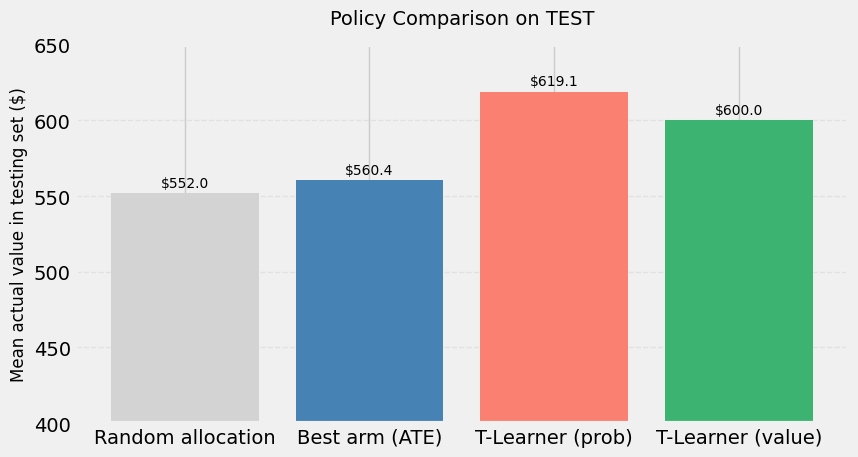

In [24]:
# fit t-learner
print("Fitting T-Learner...")
tm = BaseTClassifier(
    control_learner=LGBMClassifier(random_state=42),
    treatment_learner=LGBMClassifier(random_state=42),
    control_name='control')
tm.fit(
    df_train[x_names].values,
    df_train['treatment_control'],
    df_train['conversion'])
print("T-Learner fitted!")

Xte = df_test[x_names].values
idx = df_test.index

#  probabilities from the FITTED models
# models_c has control model, models_t has treatment model
# both are keyed by 'treatment' (the non-control group name)
control_model = tm.models_c['treatment']  #  model trained on control data
treatment_model = tm.models_t['treatment']  # model trained on treatment data

p_control = control_model.predict_proba(Xte)[:, 1] # P(conversion | control)
p_treat = treatment_model.predict_proba(Xte)[:, 1]  # P(conversion | treatment)

print(f"\nControl probs: min={p_control.min():.3f}, max={p_control.max():.3f}, mean={p_control.mean():.3f}")
print(f"Treatment probs: min={p_treat.min():.3f}, max={p_treat.max():.3f}, mean={p_treat.mean():.3f}")

# value aware choice (expected $ per row)
V, C = 1500, 150
ev_control = p_control * V
ev_treat = p_treat * (V - C)

control_label = 'control'
treat_label = 'treatment'

va_choice = np.where(ev_treat > ev_control, treat_label, control_label)

# off-policy eva (value-aware)
match_va = (df_test['treatment_control'].values == va_choice)
va_value = actual_value.loc[idx][match_va].mean()

# prob based valuation (choose arm with higher conversion probability)
prob_choice = np.where(p_treat > p_control, treat_label, control_label)
match_prob = (df_test['treatment_control'].values == prob_choice)
tm_value = actual_value.loc[idx][match_prob].mean()

print(f"\nRows used by probability policy: {int(match_prob.sum())} / {len(df_test)}")
print(f"Rows used by value-aware policy: {int(match_va.sum())} / {len(df_test)}")
print(f"Mean value (probability-based): ${tm_value:.2f}")
print(f"Mean value (value-aware): ${va_value:.2f}")
print(f"Policy agreement: {(prob_choice == va_choice).sum()} / {len(df_test)} rows")

# plot vs. baseline
labels = ['Random allocation', 'Best arm (ATE)', 'T-Learner (prob)', 'T-Learner (value)']
values = [random_allocation_value, best_ate_value, tm_value, va_value]

fig, ax = plt.subplots(figsize=(8.8, 4.8))
bars = ax.bar(labels, values, color=['lightgray', 'steelblue', 'salmon', 'mediumseagreen'])
ax.set_ylabel('Mean actual value in testing set ($)', fontsize=12)
ax.set_title('Policy Comparison on TEST', fontsize=14, pad=15)
ax.set_ylim(400, 650)
ax.grid(axis='y', linestyle='--', alpha=0.4)

for b, v in zip(bars, values):
    ax.text(b.get_x() + b.get_width()/2, v + 2, f"${v:.1f}",
            ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()

os.makedirs(PLOTS_DIR, exist_ok=True)
path = os.path.join(PLOTS_DIR, "policy_value_comparison_valueaware_test.png")
plt.savefig(path, dpi=250, bbox_inches='tight')
print(f"\n[saved] {path}")
print(dict(zip(labels, [round(v, 2) for v in values])))

plt.show()

The T-learned personalized probability-based policy \$619.15 actually outperforms the value-aware policy \$600.00.

This might happen because:

The T-Learner probability policy is selecting people more likely to convert
Even though treatment has a $150 cost, the higher conversion rate compensates for it.

Off-policy evaluation has limited overlap (only counting rows where the A/B test happened to assign the same arm we would choose).

The personalized T-Learner earns \$60-70 more per guest than doing nothing, and about $40 more than simply treating everyone with the best arm.